In [1]:
import os
import glob
import sys
import dotenv

import eolearn
from eolearn.core import (
    FeatureType,
    MergeEOPatchesTask,
    EONode,
    linearly_connect_tasks,
    EOWorkflow,
    OutputTask,
)
from eolearn.core.eoworkflow_tasks import InputTask
from eolearn.io import ImportFromTiffTask
from eolearn.ml_tools import TrainTestSplitTask

import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

root_dir = os.path.abspath('../')
if not root_dir in sys.path: sys.path.append(root_dir)

import eolearn_extras as eolx
from sdb_utils.stumpf import get_stumpf_log_ratio
from sdb_utils.acolite import ReadAcoliteProduct
from sdb_utils.ml_utils import (
    create_sdb_estimation,
    get_X_y_for_split,
    SplitType,
)

dotenv.load_dotenv()
data_root_path = os.environ.get('data_root')

In [2]:
sentinel_archives_root = os.path.abspath(os.path.join(data_root_path, 'sentinel_mile_lacs'))
sentinel_archives_pattern = f'{sentinel_archives_root}/*.SAFE'
sentinel_archives = glob.glob(sentinel_archives_pattern)
l2a_products = eolx.io.get_products_by_level(sentinel_archives, 'L2A')
l2a_products

[(datetime.datetime(2021, 4, 29, 17, 8, 51),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL2A_20210429T170851_N9999_R112_T15TVM_20220501T111454.SAFE'),
 (datetime.datetime(2021, 4, 29, 17, 8, 51),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL2A_20210429T170851_N9999_R112_T15TVM_20220501T170009.SAFE'),
 (datetime.datetime(2021, 10, 16, 17, 13, 11),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL2A_20211016T171311_N9999_R112_T15TVM_20220417T215507.SAFE'),
 (datetime.datetime(2021, 11, 25, 17, 16, 41),
  'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_MSIL2A_20211125T171641_N9999_R112_T15TVM_20220314T174330.SAFE')]

In [3]:
sentinel_acolite_folder_pattern = f'{sentinel_archives_root}/*ACOLITE*'
sentinel_acolite_folders = glob.glob(sentinel_acolite_folder_pattern)
sentinel_acolite_folders

['D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_20210429T170851_ACOLITE_SUBSET',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_20210429T170851_ACOLITE_SUBSET_minus_30_m_buffer_polygon',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_20211016T171311_ACOLITE_SUBSET',
 'D:\\sdb_datasets\\sentinel_mile_lacs\\S2A_20211125T171641_ACOLITE_SUBSET']

In [4]:
mille_lacs_bathy_path = os.path.abspath(os.path.join(data_root_path, 'mille_lacs.tiff'))
import_millie_lacs = ImportFromTiffTask((FeatureType.DATA_TIMELESS, 'bathy_data'), mille_lacs_bathy_path)
reproject_bathy = eolx.raster.ReprojectRasterTask(
    (FeatureType.DATA_TIMELESS, 'bathy_data'),
    target_resolution=(10, 10),
)
append_bathy_data_mask = eolx.bathybase.AppendBathyTimelessDataMask((FeatureType.DATA_TIMELESS, 'bathy_data'), band_index=0)

output_label = 'millie_lacs_eop'
nodes = linearly_connect_tasks(
    import_millie_lacs,
    reproject_bathy,
    append_bathy_data_mask,
    OutputTask('millie_lacs_eop')
)
workflow = EOWorkflow(nodes)

worfklow_result = workflow.execute()
millie_lacs_eop = worfklow_result.outputs[output_label]

input_bathy_task = InputTask(millie_lacs_eop)
input_bathy_node = EONode(input_bathy_task, inputs=tuple())

height, width, _ = millie_lacs_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')].shape

l2a_archive_path = l2a_products[0][1]
read_l2a_eop_task = eolx.io.ReadSentinelArchiveTask(
    target_shape=(height, width),
    bbox=millie_lacs_eop.bbox
)
read_l2a_node = EONode(read_l2a_eop_task, inputs=tuple())

acolite_product = 'L2R'
reflectance_type = 'rhos'
acolite_product_path = sentinel_acolite_folders[0]
acolite_data_feature = (FeatureType.DATA, f'{acolite_product}_data')
read_acolite_product_task = ReadAcoliteProduct(
    reference_bbox=millie_lacs_eop.bbox,
    feature=acolite_data_feature,
    acolite_product=acolite_product,
    reflectance_type=reflectance_type
)
read_acolite_node = EONode(read_acolite_product_task, inputs=tuple())

merge_patches_task = MergeEOPatchesTask()
merge_eop_node = EONode(
    merge_patches_task,
    inputs=[input_bathy_node, read_l2a_node, read_acolite_node]
)

data_feature = (FeatureType.MASK_TIMELESS, 'bathy_data_mask')
train_test_mask_feature = (FeatureType.MASK_TIMELESS, 'train_test_split')

train_test_split_task = TrainTestSplitTask(
    input_feature=data_feature,
    output_feature=train_test_mask_feature,
    bins=[0.8],
    split_type=eolearn.ml_tools.train_test_split.TrainTestSplitType.PER_PIXEL,
)
train_test_split_node = EONode(train_test_split_task, inputs=[merge_eop_node])

valid_train_test_data_mask_task = eolx.ml_util.AddValidTrainTestMasks(
    train_test_maks_feature=train_test_mask_feature,
    valid_data_mask_feature=data_feature
)
valid_train_test_data_mask_node = EONode(valid_train_test_data_mask_task, inputs=[train_test_split_node])

tt_wf_output_label = 'tt_wf_output'
output_task = OutputTask(tt_wf_output_label)
output_node = EONode(output_task, inputs=[valid_train_test_data_mask_node])

read_merge_wf = EOWorkflow(
    [
        input_bathy_node,
        read_l2a_node,
        read_acolite_node,
        merge_eop_node,
        train_test_split_node,
        valid_train_test_data_mask_node,
        output_node,
    ]
)

read_merge_wf_res = read_merge_wf.execute(
    input_kwargs={
        read_l2a_node: {'sentinel_archive_path': l2a_archive_path},
        read_acolite_node: {'acolite_product_folder': acolite_product_path},
        train_test_split_node: {'seed': 42}
    }
)

train_test_eop = read_merge_wf_res.outputs[tt_wf_output_label]
train_test_eop

EOPatch(
  data={
    L2A_data: numpy.ndarray(shape=(1, 2871, 2794, 12), dtype=uint16)
    L2R_data: numpy.ndarray(shape=(1, 2871, 2794, 11), dtype=float32)
  }
  data_timeless={
    bathy_data: numpy.ndarray(shape=(2871, 2794, 1), dtype=float32)
  }
  mask_timeless={
    bathy_data_mask: numpy.ndarray(shape=(2871, 2794, 1), dtype=uint8)
    test_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int32)
    train_split_valid: numpy.ndarray(shape=(2871, 2794, 1), dtype=int32)
    train_test_split: numpy.ndarray(shape=(2871, 2794, 1), dtype=int64)
  }
  meta_info={
    mission: 'S2A'
    test_count: 1039055
    test_perc: 0.19988842237900803
    train_count: 4159120
    train_perc: 0.8001115776209919
    validation_count: 0
    validation_perc: 0.0
  }
  bbox=BBox(((436481.4788999969, 5106398.035399999), (464421.4788999969, 5135108.035399999)), crs=CRS('26915'))
  timestamp=[datetime.datetime(2021, 4, 29, 17, 8, 51), datetime.datetime(2021, 4, 29, 17, 20, 49)]
)

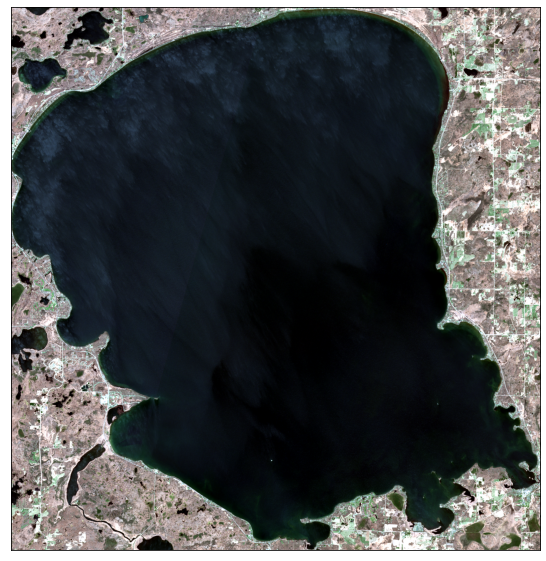

In [5]:
eolx.visualization.plot_eopatch(
    train_test_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, "L2A_data"),
    stretch=True
)
plt.show()

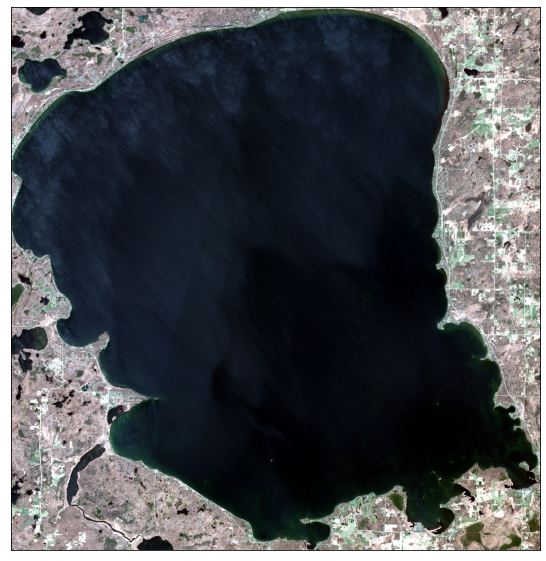

In [6]:
eolx.visualization.plot_eopatch(
    train_test_eop,
    rgb_bands=eolx.visualization.sentinel_2_true_color,
    feature=(FeatureType.DATA, f'{acolite_product}_data'),
    stretch=True
)
plt.show()

In [7]:
train_mask_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], axis=-1)

_, y_train = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Train,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)
X_train = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, 'L2A_data'), train_mask_single_band)

reg = LinearRegression()
reg.fit(X_train, y_train)

score = reg.score(X_train, y_train)
score

0.21553754996422803

In [8]:
ypred = reg.predict(X_train)
np.sqrt(mean_squared_error(y_train, ypred))

8.31117480374985

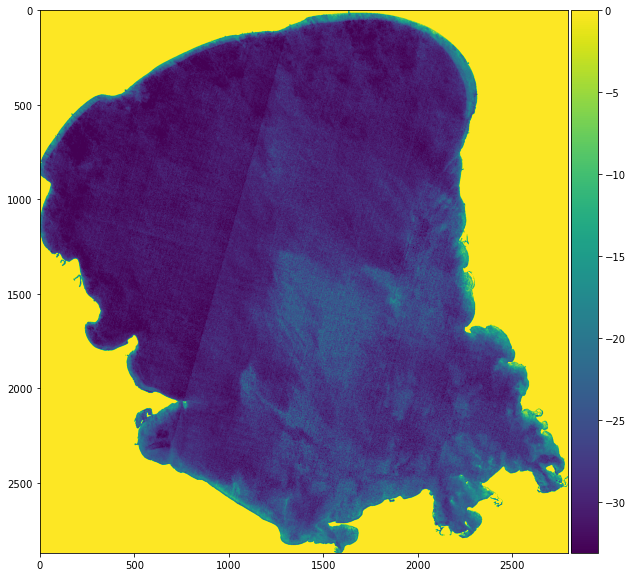

In [9]:
mask_complete_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], axis=-1)
_, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, 'L2A_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)
X_all = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, 'L2A_data'), mask_complete_single_band)

l2a_sdb_estimation_values, l2a_sdb_estimation_map = create_sdb_estimation(train_test_eop, reg, X_all)
eolx.visualization.plot_ndarray_band(l2a_sdb_estimation_map, cmap='viridis')
plt.show()

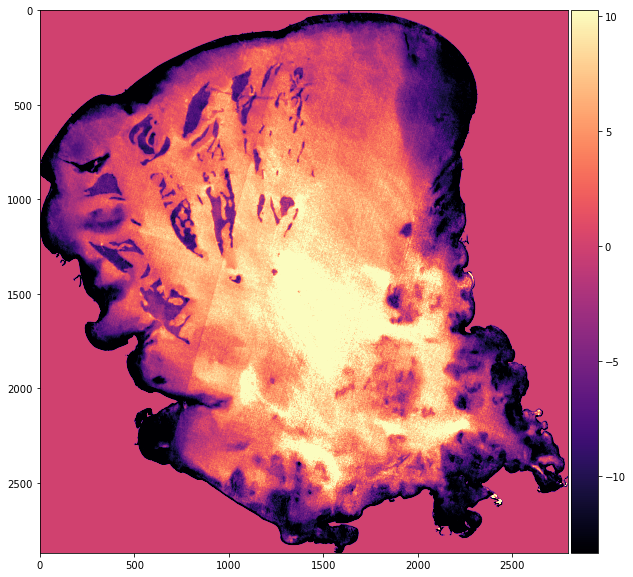

In [10]:
l2a_sdb_errors = l2a_sdb_estimation_map - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]
eolx.visualization.plot_ndarray_band(l2a_sdb_errors, cmap='magma')
plt.show()

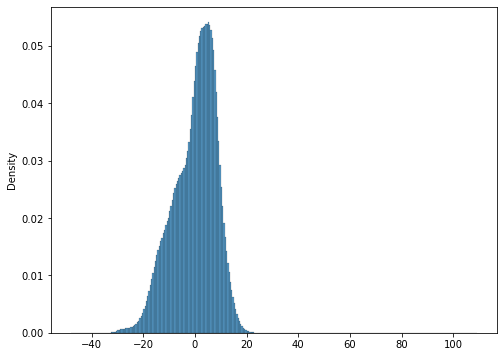

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))
l2a_sdb_residuals = l2a_sdb_estimation_values - y_all
sns.histplot(l2a_sdb_residuals, binwidth=0.5, stat='density', ax=ax)
plt.show()

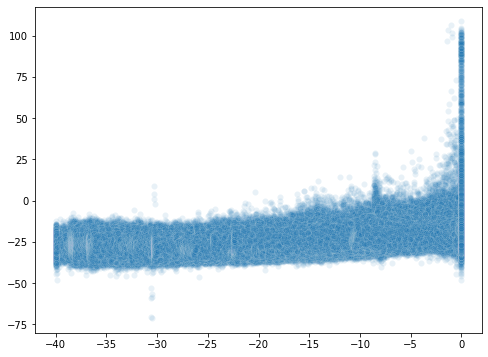

In [12]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_all, y=l2a_sdb_estimation_values, alpha=0.1, ax=ax)
plt.show()

In [13]:
np.corrcoef(y_all, l2a_sdb_estimation_values)

array([[1.        , 0.46414856],
       [0.46414856, 1.        ]])

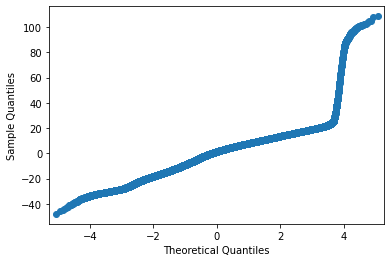

In [14]:
sm.qqplot(l2a_sdb_residuals)
plt.show()

## Stumpf Log-Ratio with Acolite

In [15]:
train_mask_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'train_split_valid')], axis=-1)

_, y_train = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.Train,
    data_feature=(FeatureType.DATA, f'{acolite_product}_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)
X_train = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, f'{acolite_product}_data'), train_mask_single_band)

reg = LinearRegression()
reg.fit(X_train, y_train)

score = reg.score(X_train, y_train)
score

0.01425713608408874

In [16]:
ypred = reg.predict(X_train)
np.sqrt(mean_squared_error(y_train, ypred))

9.316615

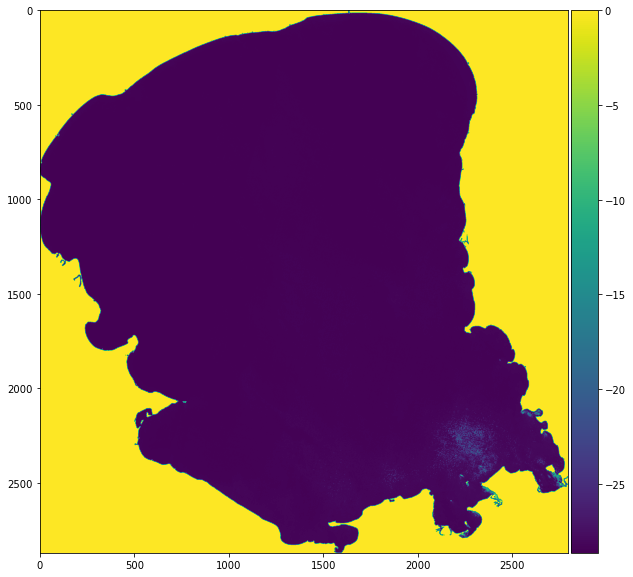

In [17]:
mask_complete_single_band = np.squeeze(train_test_eop[(FeatureType.MASK_TIMELESS, 'bathy_data_mask')], axis=-1)
_, y_all = get_X_y_for_split(
    train_test_eop,
    split_type=SplitType.All,
    data_feature=(FeatureType.DATA, f'{acolite_product}_data'),
    label_feature=(FeatureType.DATA_TIMELESS, 'bathy_data'),
)
X_all = get_stumpf_log_ratio(train_test_eop, (FeatureType.DATA, f'{acolite_product}_data'), mask_complete_single_band)

acolite_sdb_estimation_values, acolite_sdb_estimation_map = create_sdb_estimation(train_test_eop, reg, X_all)
eolx.visualization.plot_ndarray_band(acolite_sdb_estimation_map, cmap='viridis')
plt.show()

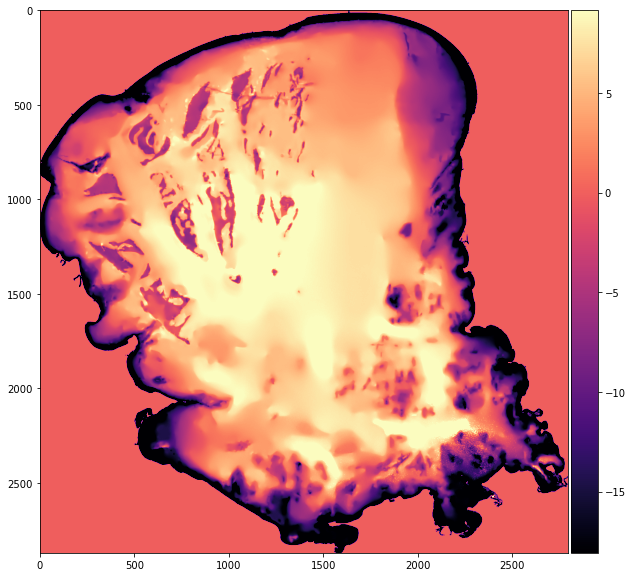

In [18]:
acolite_sdb_errors = acolite_sdb_estimation_map - train_test_eop[(FeatureType.DATA_TIMELESS, 'bathy_data')]
eolx.visualization.plot_ndarray_band(acolite_sdb_errors, cmap='magma')
plt.show()

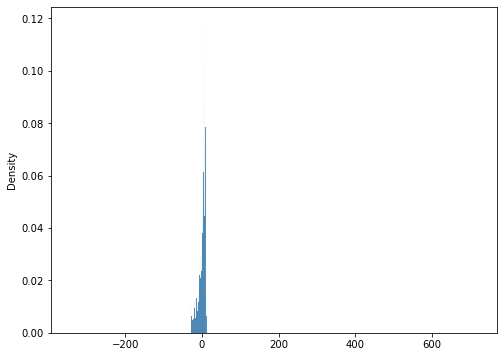

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
acolite_sdb_residuals = acolite_sdb_estimation_values - y_all
sns.histplot(acolite_sdb_residuals, binwidth=0.5, stat='density', ax=ax)
plt.show()

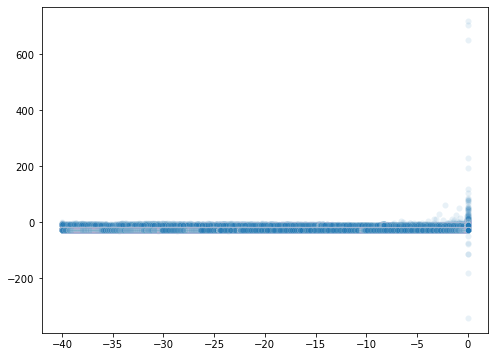

In [20]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.scatterplot(x=y_all, y=acolite_sdb_estimation_values, alpha=0.1, ax=ax)
plt.show()

In [21]:
np.corrcoef(y_all, acolite_sdb_estimation_values)

array([[1.        , 0.12362354],
       [0.12362354, 1.        ]])

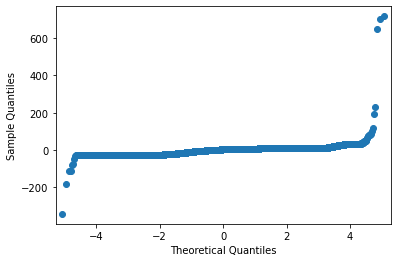

In [22]:
sm.qqplot(acolite_sdb_residuals)
plt.show()